Borad width is:  7
Borad height is: 7


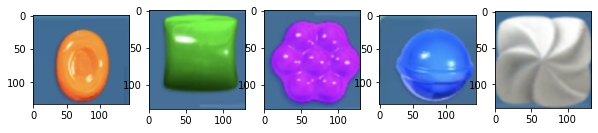

In [3]:
from itertools import product, chain
from IPython.display import Image, display
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from time import sleep
from PIL import Image as Imag
import pyautogui
import pandas as pd
from copy import deepcopy

# import logging
# logger = logging.getLogger()
# logger.setLevel(logging.DEBUG)
# logging.debug("test")

# Legal moves list
candy_all=['blue', 'red', 'green', 'violet', 'orange']

def closeButtonLookup():
    '''Looks for close button and presses it returns False if close button is not found, else - True'''
    if bool(pyautogui.locateCenterOnScreen('Images/btn_close.png', confidence=0.7))==True:
        x, y = pyautogui.locateCenterOnScreen('Images/btn_close.png', confidence=0.7)
        pyautogui.click(x/2, y/2, duration=0.5, button='right')
        print('OK,I am out of here!')
        return True
    return False

class GameState():
    
    '''Game state, board = dataframe, 'frm' and 'at' = lists of row/colum values of origin and current position'''
    
    def __init__(self,  board, parent=None, frm=None, at=None):
        self.board = board
        self.parent = parent
        self.frm = frm
        self.at = at
        self.score = 0
        self.super = False
        self.matches_vert = list()
        self.matches_horiz = list()
        self.children = list()

class Match():
    
    '''Match contains info on size, position and type of candy'''
    
    def __init__(self, typ, pos):
        self.size = pos.shape[0]
        self.pos = pos
        self.typ = typ
        obstacles = np.empty([1,1])

def find_match(selected): 
    
    '''Takes Series as an input, returns index of a match3 in the series if there is, else: None'''
    
    match=[i for i in selected.index]
    diff = [1]+[i-j for j,i in zip(match[:-1], match[1:])]
    diff = np.absolute(np.array(diff)) 
    mask = diff == 1
    if selected[mask].size>=3:
        return list(selected[mask].index)

    return 

def move_to(global_board, fr, to):

    '''Takes a Dataframe, and two lists of row/col values, swaps values in specified cells. 
        Outputs resulting Data frame '''
    local_board=global_board.copy()
    local_board.loc[fr[0], fr[1]], local_board.loc[to[0], to[1]] = local_board.loc[to[0], to[1]], local_board.loc[fr[0], fr[1]]

    return local_board

def generate_children(global_board, pos):

    '''Generate gamestates from valid moves from a given tile, pos=list of row/col values.
    Return list of gamestates.'''
    global legal_tiles
    positions = np.array(pos)
    directions = np.array([[1, 0], [0, 1], [-1, 0], [0, -1]])
    moves = np.add(positions, directions)

    # Filter the values outside of the local_board
    moves = moves[(0<=moves[:,0]) & (moves[:,0]< board_w)]
    moves = moves[(0<=moves[:,1]) & (moves[:,1]< board_h)]

    # Filter the legal_tiles moves and save them in a children nodes attribute
    children=[]
    for move in moves:
        if tuple(move) in legal_tiles:
            local_board = move_to(global_board, pos, move)
#             display(local_board)
            m = GameState(local_board, None, frm=pos, at=move)
#             print(id(m.board))
            children.append(m)

    return children

def select_type(typ, board, ind=None, col=None):

    '''Select all instances of a given type in a Series = board.iloc[index, column] 
    where board is Pandas DataFrame. When calling the function one of the kwargs MUST be given in a call'''
    
    if ind == None:
        ind=board.index, 
    if col == None:
        col=board.columns
    selected = board.loc[ind,col][board.loc[ind,col]==typ]
    if selected.size>=3:
        return selected

    return pd.Series(dtype='object')

def pix_avg(pix_array):
    """Averages the RGB values of the pixel array. Returns vector of 3 values."""
    x = np.mean(pix_array, axis=1)
    y = np.ones(133)
    return np.matmul(x.T,y)/133

#### Get input for board height and width.

board_w = int(input('Borad width is:  '))

board_h = int(input('Borad height is: '))

# wanted = input('Enter the color and amount of the wanted tiles, e.g. red, blue, orange, violet, green followed by number.')

# wanted = wanted.split()

tile_w = 138
tile_h = 133
tilesize = np.array([tile_h, tile_w])

screensize = pyautogui.size()

green = Imag.open('Images/candy_green.png')
violet = Imag.open('Images/candy_violet.png')
blue = Imag.open('Images/candy_blue.png')
orange = Imag.open('Images/candy_orange.png')
obstacle = Imag.open('Images/obstacle_1.png')

fig = plt.figure(figsize=(10, 7))
rows =1
columns =5
count=0
for im in [orange, green, violet, blue, np.array(obstacle)]:
    count+=1
    fig.add_subplot(rows, columns, count)
    plt.imshow(im)   

# Get mean RGB values
blue_mean = pix_avg(blue)
orange_mean = pix_avg(orange)
d = np.mean(violet, axis=1)
violet_mean = pix_avg(violet)
green_mean = pix_avg(green)
obstacle_mean = pix_avg(obstacle)

candy_rgb = pd.DataFrame([green_mean, blue_mean, violet_mean, orange_mean, obstacle_mean], index =['green','blue','violet','orange','obstacle'])

all_tiles = list(product(range(board_h),range(board_w)))

#### Create a dictionary of coordinates for mouse drags.

game_scr_size =  board_w * tile_w, board_h * tile_h
corner = screensize[1]*2 - game_scr_size[1]
tilecenters = {pos:(np.flip(np.array(pos)*tilesize+np.array([screensize[1]*2 - game_scr_size[1],0])+67)/2).astype(int) for pos in all_tiles}

OK,I am out of here!


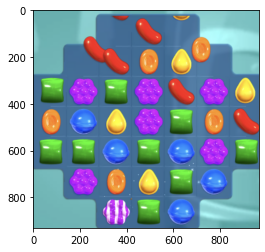

In [4]:
## Scan the game area, identify the cell contentns.
while True:
#     See if we are on the map yet
    if bool(pyautogui.locateOnScreen('Images/map.png', confidence=0.7))==True:
        print("I'm back to the map.")
        break
    if closeButtonLookup()==True:
        break
    t=pyautogui.screenshot('Images/board_ss.png',region=(10, corner, game_scr_size[0], game_scr_size[1]))

    image = Imag.open("Images/board_ss.png")
    image_array = np.array(image)
    plt.imshow(image)

    ### Split game ss to tiles.

    all_vals = []
#     fig = plt.figure(figsize=(board_w, board_h))
#     rows = board_h
#     columns = board_w
    count=0  
    for i in all_tiles:
        count+=1
#         fig.add_subplot(rows, columns, count)
        starts = np.array(i) 
        ends = np.array(i)+1 
        start = (starts * tilesize ).astype(int)
        end = (ends * tilesize).astype(int)
        all_vals.append(image_array[start[0]:end[0], start[1]:end[1]])
#         plt.imshow(image_array[start[0]:end[0], start[1]:end[1]])

    ## Create a representation of the game board.

    board = pd.DataFrame('0', index=range(board_h), columns=range(board_w))
    Root = GameState(board) 

    for pos, array in zip(all_tiles, all_vals):
        error = np.matmul(np.abs(candy_rgb.to_numpy()-pix_avg(array).T), np.ones(4))
        typ = candy_rgb.index[np.argmin(error)]
        Root.board.loc[pos] = typ

    Root.board

    ## Look for the matches

    # legal_tiles: in the game only candies can move
    legal_tiles = [tile for tile in all_tiles if Root.board.iloc[tile[0], tile[1]] in candy_all]
    legal_tiles
    # testboard = 

    candidates = list()

    for tile in legal_tiles:
        candidates.extend(generate_children(Root.board.copy(), tile))

#     for cand in candidates:
#         display(cand.board)

    ### Look for matches in the resulting boards.

    for candidate in candidates:
        # Column-wise
        # Get types of the match to look for.
        types=[]
        types.append(candidate.board.iloc[candidate.frm[0], candidate.frm[1]])
        types.append(candidate.board.iloc[candidate.at[0], candidate.at[1]])
        for typ in types:

            # Search the column for the values of the given type
            res_vert = {i : select_type(typ, candidate.board, col=i) for i in candidate.board.columns 
                        if select_type(typ, candidate.board, col=i).any()}

            # Now look for actual matches in the result of the search
            for key, val in res_vert.items():
                            match = find_match(val)
                            if match:
                                candidate.matches_vert.append( Match( val.all(), candidate.board.loc[match,key] ))
            # And row-wise
            res_horiz = {i : select_type(typ, candidate.board, ind=i) for i in candidate.board.index 
                         if select_type(typ, candidate.board, ind=i).any()}

            for key, val in res_horiz.items():
                            match = find_match(val)
                            if match:
                                candidate.matches_horiz.append( Match( val.all(), candidate.board.loc[key, match] ))

    pd.DataFrame([i.matches_vert[0].pos for i in candidates if i.matches_vert])

    pd.DataFrame([cand.matches_horiz[0].pos for cand in candidates if cand.matches_horiz])

    ### Prune the children. Keep boards with matches, delete the rest.

    # Choose candidates that have vertical matches:
    vert_cands = [cand for cand in candidates if any(cand.matches_vert)]

    # Choose candidates that have horizontal matches:
    horiz_cands = [cand for cand in candidates if any(cand.matches_horiz)]

    ### Evaluate children

    selected = []

    # Look for double matches of the same type as they are likely to indicate super matches
    # Select cadidates that have matches in both horiz and vert, check if both matches are same color.

    # TODO: add bonus score for a sertain amount of certain type of candy.

    # TODO: add score for obstacles in neighbouring board cells.

    for gamestate in filter(lambda x: x in horiz_cands, vert_cands):
    #     display(gamestate.board)
        if any([i.typ==j.typ for i in gamestate.matches_vert for j in gamestate.matches_horiz]):
            gamestate.super=True
        selected.append(gamestate)    

    # Sum of all matches sizes in the GameState
    def sum_score(instance):
        s = sum([match.size for match in instance.matches_horiz]) + sum(match.size for match in instance.matches_vert)   
        return s



    if horiz_cands:
        main_candidate_horiz = max(horiz_cands, key=sum_score)
        if any([match.size>3 for match in main_candidate_horiz.matches_horiz]):
            main_candidate_horiz.super = True

        main_candidate_horiz.score += sum_score(main_candidate_horiz)
        selected.append(main_candidate_horiz)


    if vert_cands:
        main_candidate_vert = max(vert_cands, key=sum_score)
        if any([match.size>3 for match in main_candidate_vert.matches_vert]):
            main_candidate_vert.super = True

        main_candidate_vert.score += sum_score(main_candidate_vert)
        selected.append(main_candidate_vert)

    best = max(selected, key = lambda x: x.score)
    best.board

    pyautogui.moveTo(tilecenters[best.frm][0], tilecenters[best.frm][1])

    pyautogui.dragTo(tilecenters[tuple(best.at)][0], tilecenters[tuple(best.at)][1], button='right')
    sleep(2)